# Error correction with cat qubits

A central obstacle to building useful quantum computers is the prevalence of hardware-level noise, which corrupts quantum information long before meaningful computations can be completed. Quantum error correction addresses this challenge by encoding a single logical qubit across many noisy physical qubits, allowing errors to be detected and corrected without destroying the encoded information.

Dissipative cat qubits encode one logical qubit in the phase space of a quantum harmonic oscillator, also known as a bosonic mode. As the average photon number increases, the phase-flip error rate of a cat qubit can be suppressed exponentially, while the bit-flip error rate grows only linearly [[REF](https://arxiv.org/pdf/1907.11729)]. This asymmetry enables access to regimes of strong noise bias, where phase-flip errors can, in principle, be made arbitrarily rare, leaving bit-flip errors as the dominant remaining failure mode.

This noise bias can be exploited by concatenating cat qubits with higher-level quantum error-correcting codes that are optimized to suppress bit-flip errors. The result is a substantial reduction in the number of physical resources required to achieve fault-tolerant quantum computation, compared to architectures based on unbiased qubits.

In this challenge, you will explore how cat qubits enable significant reductions in hardware overhead for fault-tolerant quantum computing. You will also investigate novel error-correcting codes that are particularly well suited for concatenation with cat qubits, further reducing complexity and resource requirements.

**NOTE:** All subtasks in this notebook are marked with `[TODO]`. You can use Ctrl/Cmd+F to find them and make sure you do not miss any. In some places, you will also see sections labeled `# SOLUTION ===`, which indicate where you should add code to complete the task.

# 1 - Installations


Begin by uncommenting and running the cell below to install the dependencies needed for this challenge.

In [1]:
!pip install stim~=1.15
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy
!pip install pymatching~=2.0
!pip install sinter~=1.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.1/626.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 kB 6.8 MB/s eta 0:00:00


In [2]:
import stim
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import os
import numpy as np


print(stim.__version__)

1.15.0


# 2 - Bell states & Error Detection Codes

The following section demonstrates the creation and measurement of a bell state:

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

Then, we will use bell states as codewords for the smallest error detection code.

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

H 0
CX 0 1
M 0 1

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-



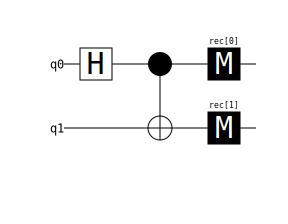

In [4]:
print(circuit)
print("")
print(circuit.diagram())
print("")
circuit.diagram('timeline-svg')

Now, we can sample this circuit and, in doing so, measure the state of each qubit.

In [5]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False]])

Here, False means 0 and True means 1. Notice how the results of the measurement qubit 0 and the measurement on qubit 1 always match, as expected of a bell state. So, we can expect a parity measurement between the two qubits to always be 0, since the two qubits will always have the same state. In stim, the parity is measured using a "DETECTOR" operation, as shown below:

In [6]:
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [7]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


Now, let's add X errors onto each qubit.

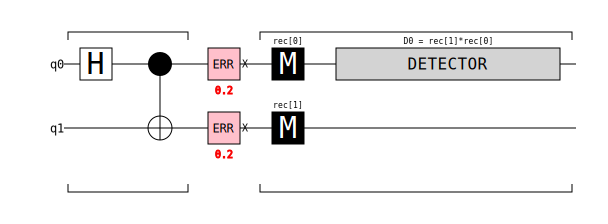

In [8]:
p = 0.2
circuit = stim.Circuit(f"""
    H 0
    CX 0 1

    TICK
    X_ERROR({p}) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

circuit.diagram('timeline-svg')

In [9]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]]


With stim, we can quickly collect many samples, extracting the detector hit rate, which should be:

$$p*(1-p)*2$$

In [10]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)
print(p*(1-p)*2)

0.31945
0.32000000000000006


## Task 2.1: Error detection code

[TODO, 10pts]: As shown, in the absence of noise the parity between the two qubits in a Bell state is fixed.

The presence of a single-qubit bit-flip error changes this parity, which appears as a nonzero detector outcome when the stabilizer $Z_0 Z_1$ is measured. This observation can be used to construct the simplest quantum error-detecting code, the two-qubit code $[[2,1,1]]$. In the notation $[[n,k,d]]$, $n$ is the number of physical qubits, $k$ is the number of logical qubits, and $d$ is the code distance. The distance $d$ is the minimum weight of a Pauli operator that preserves the codespace while acting nontrivially on the logical information.

You will now implement a $[[2,1,1]]$ code using two data qubits and one ancilla qubit to measure the stabilizer $Z_0 Z_1$. A convenient choice of logical basis states within the codespace is

$$
\ket{0_L} = \ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}, \qquad
\ket{1_L} = \ket{\Phi^-} = \frac{\ket{00} - \ket{11}}{\sqrt{2}}.
$$

Assume that each data qubit undergoes an independent $X$ error with probability $p = 0.1$. An odd number of bit flips anticommutes with $Z_0 Z_1$ and is therefore detected by the parity check. By postselecting on runs with a trivial detector outcome (i.e. detector = False), all such odd-parity leakage error events are removed. These are denoted leakage errors, as they the qubits out of the codespace, spanned by superpositions of the codewords.


As a result, postselection suppresses all first-order physical bit-flip errors. The only remaining error process on the accepted runs is the even-parity event $X_0 X_1$, which is a logical identity operator as both codewords are in its +1 eigenbasis.

Set up this code, simulate it with X errors on each data qubit after the preparation of a bell state, and show that leakage errors and logical errors are fully suppressed with postselection on no detector events. Calculate the success probability of no detector errors occurring as a function of the physical error rate $p$ and show that it matches your simulation.

In [11]:
# SOLUTION ===
# initialize stim circuit needed for this simulation

p = 0.1

# Qubits: 0, 1 are data qubits; 2 is the ancilla for parity check
circuit = stim.Circuit(f"""
    # Initialize all qubits
    R 0 1 2

    # Prepare Bell state |Φ+> (Logical |0_L>)
    H 0
    CX 0 1

    TICK
    # Apply noise (Bit-flips with probability p)
    X_ERROR({p}) 0 1
    TICK

    # Measure parity Z0Z1 using ancilla (q2 = q0 XOR q1)
    CX 0 2
    CX 1 2

    # Measure ancilla - result is at rec[-1]
    M 2
    # Flag a detector if the measurement result is 1 (parity flip detected)
    DETECTOR rec[-1]

    TICK
    # Final data qubit measurements to verify the logical state
    M 0 1
""")
# ===

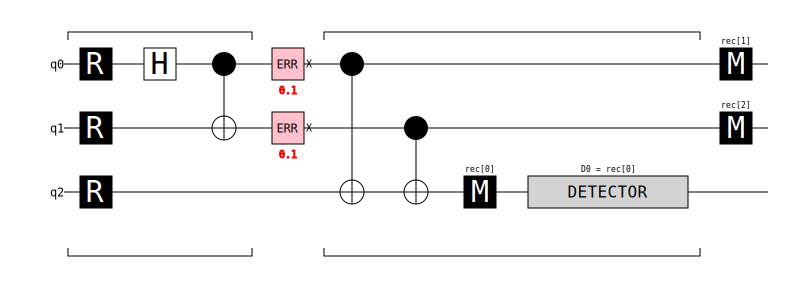

In [12]:
circuit.diagram('timeline-svg')

In [13]:
# SOLUTION ===
# run/sample simulation to calculated a simulated logical error rate

num_shots = 1_000_000
sampler = circuit.compile_sampler()
all_samples = sampler.sample(shots=num_shots)

# all_samples[:, 0] is the ancilla (syndrome)
# all_samples[:, 1] and [:, 2] are the data qubits q0 and q1
ancilla_results = all_samples[:, 0]
q0_results = all_samples[:, 1]
q1_results = all_samples[:, 2]

# Postselect: Keep only runs where the detector did NOT fire (ancilla == 0)
postselect_mask = (ancilla_results == 0)
accepted_q0 = q0_results[postselect_mask]
accepted_q1 = q1_results[postselect_mask]

# Calculate logical errors: In |0_L>, q0 and q1 should be the same (parity 0)
# An error occurred if q0 != q1 in the accepted results
logical_errors = np.sum(accepted_q0 != accepted_q1)

# Final Metrics
total_accepted = np.sum(postselect_mask)
simulated_logical_error_rate = logical_errors / total_accepted if total_accepted > 0 else 0.0
# ===

In [14]:
p = 0.1
success_prob = 1 - p*(1-p)*2
print("success probability:", success_prob, simulated_logical_error_rate)

success probability: 0.82 0.0


# 3 - Repetition Code

## Task 3.1 Implement a decoder for the repetition code.

[TODO, 5pts]: You will now implement and simulate the $n$-qubit repetition code with asymmetric distance $[[n,1,d_X=n,d_Z=1]]$, defined by the logical codewords

$$
\ket{0_L} = \ket{000\cdots 0}, \qquad
\ket{1_L} = \ket{111\cdots 1}.
$$

The stabilizer group is generated by the $n-1$ nearest-neighbor parity checks

$$
Z_i Z_{i+1}, \qquad i = 0, \dots, n-2 .
$$

These stabilizers extract $n-1$ independent bits of syndrome information, leaving exactly one protected logical degree of freedom. In other words, the code encodes a single logical qubit into $n$ physical qubits. A convenient choice of logical operators is

$$
X_L = X_0 X_1 \cdots X_{n-1}, \qquad Z_L = Z_0 \ \ (\text{equivalently any } Z_i),
$$

so the code has $X$-distance $d_X=n$ (it protects against bit-flip errors up to weight $\lfloor (n-1)/2\rfloor$) but only $Z$-distance $d_Z=1$.

Your first task is to implement a decoder that takes as input a final measurement of all data qubits together with a single round of stabilizer measurements, and outputs the most likely logical state. Rather than using a simple majority-vote rule, your decoder should explicitly use the stabilizer syndromes to infer a most likely correction consistent with the observed syndrome, apply that correction to the final data-qubit measurements, and then determine the decoded logical value. This approach is more scalable to real-time quantum error correction, where stabilizer measurements can be used to decode errors and apply corrections during an algorithm to recover back to the codespace and protect logical information.

*Note: For codes used with biased physical noise, it is often useful to specify separate distances $d_X$ (the minimum weight nontrivial logical $X$ operator) and $d_Z$ (the minimum weight nontrivial logical $Z$ operator), rather than quoting a single distance $d=\min(d_X,d_Z)$.


In [15]:
from typing import Tuple

def decode_repetition_code(
    meas: Tuple[str, str],
) -> int:
    """
    Decode an n-qubit classical repetition code using Minimum Weight Perfect Matching (MWPM) logic.
    """
    # SOLUTION ===

    # 1. Parse inputs into integer lists
    data_bits = [int(b) for b in meas[0]]        # e.g., "00001" -> [0, 0, 0, 0, 1]
    stabilizer_bits = [int(b) for b in meas[1]]  # e.g., "0001"  -> [0, 0, 0, 1]
    n = len(data_bits)

    # 2. Construct the "Relative Error Mask"
    # This mask represents the error pattern assuming the first qubit (q0) is correct.
    # We walk down the chain: a '1' in the syndrome means the error status flips.

    # mask[i] = 1 means we think qubit i has a bit-flip error relative to q0
    error_mask = [0] * n

    current_error_status = 0 # Start assuming q0 has 0 error
    error_mask[0] = current_error_status

    for i, syndrome in enumerate(stabilizer_bits):
        if syndrome == 1:
            # Domain wall: The error status changes between i and i+1
            current_error_status = 1 - current_error_status

        error_mask[i+1] = current_error_status

    # 3. Minimum Weight Decision (MWPM)
    # The 'error_mask' is one valid explanation for the syndrome.
    # The complement (flipping every bit in error_mask) is the OTHER valid explanation.
    # We choose the one with fewer errors (lower weight) because errors are rare (p < 0.5).

    weight_primary = sum(error_mask)
    weight_complement = n - weight_primary

    final_correction = []

    if weight_primary <= weight_complement:
        # The primary hypothesis (q0 was correct) is more likely
        final_correction = error_mask
    else:
        # The complement hypothesis (q0 was wrong, everything is flipped) is more likely
        final_correction = [1 - bit for bit in error_mask]

    # 4. Apply Correction and Decode
    # We apply the calculated correction to the noisy data_bits.
    # If successful, corrected_data will be all 0s or all 1s.

    corrected_data_bit_0 = data_bits[0] ^ final_correction[0]

    # Since the corrected state should be uniform (00...0 or 11...1),
    # we can just return the first bit.
    return corrected_data_bit_0

    # ===


# Example:
print(decode_repetition_code(("00001", "0001")))  # -> 0
print(decode_repetition_code(("00011", "0011")))  # -> 0

0
0


## Task 3.2 - Simulate logical error rates

[TODO, 5pts]: Now, set up stim circuits to prepare logical $\ket{0_L}$ or $\ket{1_L}$. This circuit should contain $n$ data qubits and $n-1$ measure qubits that are used to measure parity between neighboring data qubits. Then, insert X errors on the data qubits with probability $p$ after initializing qubits to logical $\ket{0_L}$ or $\ket{1_L}$, measure the parity stabilizers $Z_{i}Z_{i+1}$ with measure qubits, and finally measure the state of each data qubit.

Then, using your decoder, decode what the logical state should be for each possible scenario. The ratio of when you decoded incorrectly over the total number of shots is your logical error probability $p_L$.

Make a plot of $p_L$ vs physical error probability (sampled logarithmically) $p \in [0.1, 0.5]$ for $n \in [3,5,7,9]$. Both axes in this plot should be on a log scale. At what value of $p$ do you see a threshold, the point where increasing $n$ helps to suppress logical errors?

In [53]:
# e.g. 3-qubit rep code

circuit = stim.Circuit('''
    R 0 1 2 3 4

    TICK
    X_ERROR(0.1) 0 2 4

    TICK
    CX 0 1 2 3

    TICK
    CX 2 1 4 3

    TICK
    MR 1 3

    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    TICK
    M 0 2 4
    OBSERVABLE_INCLUDE(0) rec[-3]
    OBSERVABLE_INCLUDE(1) rec[-2]
    OBSERVABLE_INCLUDE(2) rec[-1]
''')

In [54]:
from collections import Counter

# generalized rep code

def repetition_code_circuit(n: int, p: float = 0.1) -> stim.Circuit:
    """
    Build an n-qubit repetition code circuit using a Stim string.

    Layout:
      data qubits:   0, 2, 4, ..., 2(n-1)
      ancilla qubits:1, 3, 5, ..., 2(n-2)+1

    Total qubits: 2n-1
    """

    # SOLUTION ===

    circuit = stim.Circuit()

    # Calculate indices based on the prompt's layout:
    # Data qubits: 0, 2, 4, ...
    data_qubits = [2 * i for i in range(n)]
    # Ancilla qubits: 1, 3, 5, ...
    ancilla_qubits = [2 * i + 1 for i in range(n - 1)]
    # All qubits used (max index is 2*n - 2, so range size is 2*n - 1)
    all_qubits = list(range(2 * n - 1))

    # 1. Initialize all qubits
    circuit.append("R", all_qubits)
    circuit.append("TICK")

    # 2. Apply Noise (Bit-flips on data qubits only)
    circuit.append("X_ERROR", data_qubits, p)
    circuit.append("TICK")

    # 3. Measure Stabilizers (Z_i Z_{i+1})
    # For each ancilla at index `a`, we CNOT from left data `a-1` and right data `a+1`
    for i in range(n - 1):
        ancilla = 2 * i + 1
        left_data = 2 * i
        right_data = 2 * (i + 1)

        circuit.append("CX", [left_data, ancilla])
        circuit.append("CX", [right_data, ancilla])

    circuit.append("TICK")

    # 4. Measure everything
    # Important: Measure ancillas FIRST to match the decoder's expected input format
    circuit.append("M", ancilla_qubits)
    circuit.append("M", data_qubits)

    return circuit
    # ===


def simulate_circuit(circuit, n, num_shots=100_000):
    """
    Simulate the circuit and return the results.

    Args:
        circuit: The circuit to simulate.
        n: The number of data qubits.

    Returns:
        results: {(data_bits, stabilizer_bits): counts}
    """

    # SOLUTION ===

    # Compile the sampler
    sampler = circuit.compile_sampler()
    # Run simulation
    raw_samples = sampler.sample(shots=num_shots)

    # Process results
    # The circuit measures (n-1) ancillas FIRST, then n data qubits SECOND.
    num_stabilizers = n - 1

    counts = Counter()

    for sample in raw_samples:
        # Extract bits (stim returns numpy bool/int8 array)
        # First part is stabilizer measurements
        stab_bits_array = sample[:num_stabilizers]
        # Second part is data measurements
        data_bits_array = sample[num_stabilizers:]

        # Convert to strings for the decoder dictionary key
        stab_str = "".join(str(int(b)) for b in stab_bits_array)
        data_str = "".join(str(int(b)) for b in data_bits_array)

        counts[(data_str, stab_str)] += 1

    return counts

    # ===

def logical_error_rate(
    results: dict[tuple[str, str], int],
    logical_prepared: int = 0,
) -> float:
    """
    Compute logical error rate using decode_repetition_code.

    Args:
        results: {(data_bits, stabilizer_bits): counts}
        logical_prepared: 0 or 1 logical state that was prepared.

    Returns:
        Logical error probability.
    """

    # SOLUTION ===

    total_shots = sum(results.values())
    failed_shots = 0

    for (data_str, stab_str), count in results.items():
        # Use the decoder function you wrote in Task 3.1
        predicted_logical = decode_repetition_code((data_str, stab_str))

        if predicted_logical != logical_prepared:
            failed_shots += count

    return failed_shots / total_shots

    # ===


def run_sim(n, p):
    circuit = repetition_code_circuit(n, p=p)
    results = simulate_circuit(circuit, n)
    return logical_error_rate(results, logical_prepared=0)

In [55]:
# Example
n = 5
p = 0.1
circuit = repetition_code_circuit(n, p=p)

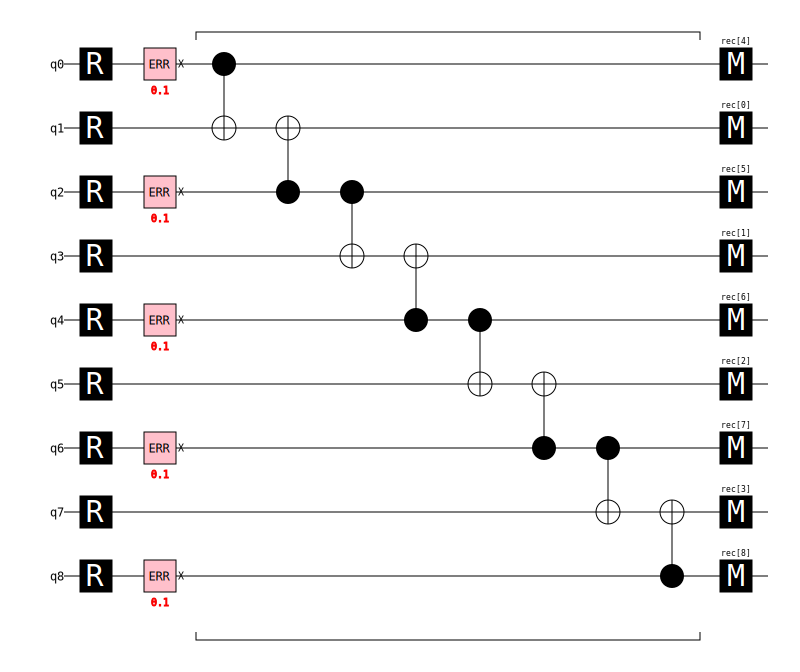

In [56]:
circuit.diagram('timeline-svg')

In [57]:
results = simulate_circuit(circuit, n)
results

Counter({('00000', '0000'): 58800,
         ('10000', '1000'): 6684,
         ('11000', '0100'): 756,
         ('00001', '0001'): 6526,
         ('10001', '1001'): 695,
         ('01010', '1111'): 727,
         ('00100', '0110'): 6427,
         ('01000', '1100'): 6726,
         ('00010', '0011'): 6585,
         ('01001', '1101'): 764,
         ('00111', '0100'): 77,
         ('10010', '1011'): 740,
         ('10100', '1110'): 694,
         ('00110', '0101'): 766,
         ('00101', '0111'): 739,
         ('11010', '0111'): 92,
         ('01011', '1110'): 86,
         ('01100', '1010'): 741,
         ('00011', '0010'): 751,
         ('10110', '1101'): 92,
         ('11001', '0101'): 85,
         ('10011', '1010'): 85,
         ('11100', '0010'): 86,
         ('01101', '1011'): 81,
         ('01110', '1001'): 71,
         ('10111', '1100'): 9,
         ('01111', '1000'): 7,
         ('11101', '0011'): 6,
         ('10101', '1111'): 88,
         ('11011', '0110'): 9,
         ('11110', '0

In [59]:
print(logical_error_rate(results, logical_prepared=0))

import math
def theory_logical_error_prob(n, p):
    return sum(
        math.comb(n, k)*p**k*(1-p)**(n-k)
        for k in range((n+1)//2, n+1)
    )

print(theory_logical_error_prob(n, p))

0.00879
0.008560000000000002


In [60]:
error_probabilities = np.logspace(-1, np.log10(0.5), 21)
distances = [3, 5, 7, 9]

# SOLUTION ===
# collect simulation data for varying distances and error_probabilities

# SOLUTION ===
# collect simulation data for varying distances and error_probabilities

data_points = {} # Store results as {n: [rates...]}

for n in distances:
    print(f"Simulating Distance n={n}...")
    rates = []
    for p in error_probabilities:
        # 1. Build Circuit
        circuit = repetition_code_circuit(n, p)

        # 2. Simulate
        # Note: lowering shots slightly to speed up simulation for the plot
        results = simulate_circuit(circuit, n, num_shots=20_000)

        # 3. Calculate Error Rate
        p_L = logical_error_rate(results, logical_prepared=0)
        rates.append(p_L)

    data_points[n] = rates
# ===

# ===

Simulating Distance n=3...
Simulating Distance n=5...
Simulating Distance n=7...
Simulating Distance n=9...


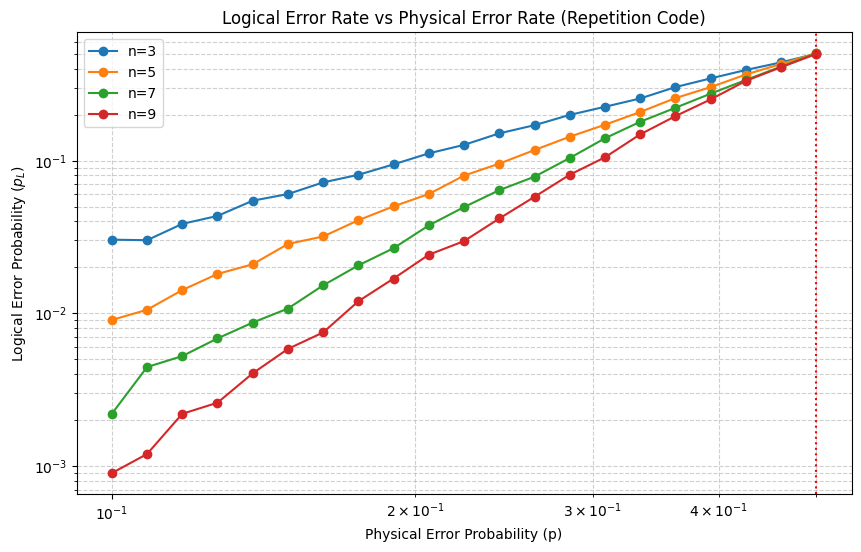

In [61]:
# SOLUTION ===
# plot results

plt.figure(figsize=(10, 6))

for n in distances:
    plt.loglog(error_probabilities, data_points[n], 'o-', label=f'n={n}')

plt.title("Logical Error Rate vs Physical Error Rate (Repetition Code)")
plt.xlabel("Physical Error Probability (p)")
plt.ylabel("Logical Error Probability ($p_L$)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.axvline(x=0.5, color='red', linestyle=':', label='Threshold (0.5)')
plt.show()
# ===

# 4 - Compare surface code vs cat-repetition code

In this section, we will benchmark the cat-repetition code against a conventional surface code built from unbiased qubits. While the surface code is designed to protect against general, symmetric noise, the cat-repetition code is optimized for a strongly biased error channel in which phase flips are exponentially suppressed and bit flips dominate. By comparing these two architectures under their respective noise models, we can directly evaluate the advantages of exploiting hardware bias. We will focus on resource efficiency, logical error rates, and scaling with system size to highlight when and why a bias-tailored code can outperform a more general-purpose quantum error correcting code.

Here is an especially useful resource for this section:
[https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)

Please feel free to adapt code from the above notebook. The point of the tasks in this section is to explore logical error rates and hardware resource overheads in different parameter regimes, not figure out syntax.

## Task 4.1 - cat-repetition code threshold

Since cat qubits can exponentially suppress phase-flip errors, the dominant remaining noise channel is bit flips on the encoded qubits. In this task, you will study how the logical error rate scales with the number of cat qubits used as data qubits in a repetition code, assuming each data qubit experiences a fixed bit-flip error rate.

[TODO, 2.5pts]: First, complete `generate_rep_code_bit_flips` to return a repetition-code memory circuit with distance `d`, `3d` rounds, and bit-flip noise applied as `X_ERROR(noise)` on the data qubits. You may use Stim’s built-in repetition-code memory generator rather than implementing the circuit from scratch.

In [48]:
def generate_rep_code_bit_flips(d, noise):
    # SOLUTION ===

    # 1. Generate the circuit structure
    generated_circuit = stim.Circuit.generated(
        "repetition_code:memory",
        distance=d,
        rounds=3 * d,
        before_round_data_depolarization=noise
    )

    # 2. FLATTEN the circuit to expose instructions inside REPEAT blocks
    # This unrolls the loops so we can access the noise gates directly.
    flattened_circuit = generated_circuit.flattened()

    # 3. Transmute the noise
    circuit = stim.Circuit()
    for instruction in flattened_circuit:
        if instruction.name == "DEPOLARIZE1":
            # Replace DEPOLARIZE1(p) with X_ERROR(p)
            circuit.append("X_ERROR", instruction.targets_copy(), instruction.gate_args_copy()[0])
        else:
            circuit.append(instruction)

    return circuit
    # ===

We can then use this repetition code generation function to once again extract a threshold.

In [49]:
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

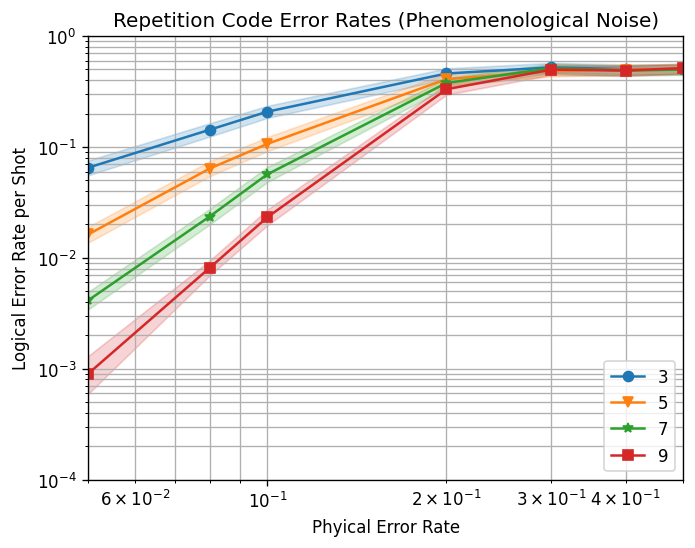

In [50]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

[TODO, 2.5pts]: Next, fix the physical bit-flip probability to $p_X = 0.01$. Assuming a cat-qubit noise bias of $10^8$, the corresponding phase-flip probability is $p_Z = 10^{-10}$. How many cat qubits are required in a repetition code to suppress the logical bit-flip probability below $10^{-10}$, so that it is comparable to the phase-flip level?

These parameter choices are loosely inspired by the following references, which provide a more detailed and rigorous analysis of error correction with cat qubits:
- [https://arxiv.org/abs/2302.06639](https://arxiv.org/abs/2302.06639)
- [https://arxiv.org/abs/2401.09541](https://arxiv.org/abs/2401.09541)

Make a plot of logical error rate versus code distance $d$ for fixed $p_X = 0.01$. Note that the code distance $d$ is equal to the number of data qubits $n$ for the repetition code. Use `generate_rep_code_bit_flips`, which injects only bit flips, since phase flips are negligible in this regime.


log10(p_L) ≈ -0.640 * d + -0.685
R^2 = 0.9903
Estimated distance for p_L ≈ 1e-10: d ≈ 14.57
Required cat qubits: 15


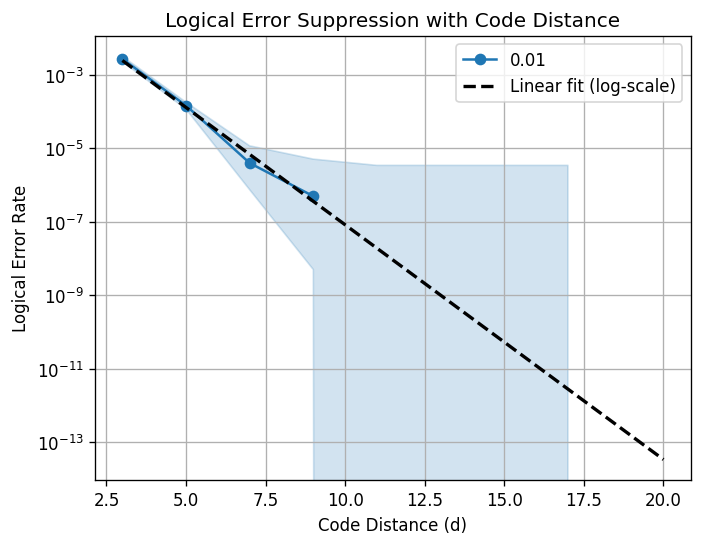

In [52]:
import numpy as np
import math
from scipy.stats import linregress

tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, 0.01),
        json_metadata={'d': d, 'p': 0.01},
    )
    for d in [3, 5, 7, 9, 11, 13, 15, 17]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=2000000,
    max_errors=500,
)

fig, ax = plt.subplots(1, 1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['d'],      # X-axis is now Distance (d)
    group_func=lambda stats: stats.json_metadata['p'],  # Lines are grouped by Physical Error (p)
)

# ax.set_ylim(1e-10, 1e-0)  # Adjust based on your data (e.g. 1e-10 if looking for cat qubits)
# ax.set_xlim(0, 25)        # Adjust to cover your distances
ax.semilogy()               # Use semilogy (Linear X, Log Y) to see the straight-line suppression
ax.set_title("Logical Error Suppression with Code Distance")
ax.set_xlabel("Code Distance (d)")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor', alpha=0.3)
ax.legend(title="Physical Error (p)")
fig.set_dpi(120)

# --- Extract valid (nonzero) data points ---
ds = []
log_pLs = []

for stats in collected_stats:
    if stats.errors > 0:
        d = stats.json_metadata['d']
        p_L = stats.errors / stats.shots
        ds.append(d)
        log_pLs.append(np.log10(p_L))

ds = np.array(ds)
log_pLs = np.array(log_pLs)

# --- Linear regression: log10(p_L) = m*d + b ---
slope, intercept, r_value, p_value, std_err = linregress(ds, log_pLs)

print(f"log10(p_L) ≈ {slope:.3f} * d + {intercept:.3f}")
print(f"R^2 = {r_value**2:.4f}")

# --- Solve for p_L = 1e-10 ---
target_log_pL = -10
d_target = (target_log_pL - intercept) / slope

print(f"Estimated distance for p_L ≈ 1e-10: d ≈ {d_target:.2f}")
print(f"Required cat qubits: {math.ceil(d_target)}")

# Draw linear regression (log10 scale)
d_fit = np.linspace(min(ds), 20, 200)
pL_fit = 10 ** (slope * d_fit + intercept)

ax.plot(d_fit, pL_fit, '--', color='black', linewidth=2, label='Linear fit (log-scale)')
ax.legend()

## 4.2 - surface code benchmarks

The surface code can be viewed as a two-dimensional generalization of the repetition code that protects against both bit-flip and phase-flip errors. For this reason, many groups are pursuing surface-code architectures built from unbiased qubits (such as transmons) to suppress both types of logical errors simultaneously.

Next, we will generate an analogous plot of logical error rate versus the number of data qubits for a fixed physical depolarizing error probability of 0.001 using the surface code. From this, we will estimate how many qubits are required to reach a logical error rate of ($10^{-10}$), enabling a direct comparison with the cat-repetition results.


### 4.2.1 - surface code threshold

[TODO, 2.5pts]: First, complete `generate_surface_code_depolraizing_noise` to return a surface-code memory circuit with distance `d`, `3d` rounds, and depolarizing noise applied on data qubits. You may use Stim’s built-in surface-code memory generator and flags rather than implementing the circuit from scratch.

In [28]:
def generate_surface_code_depolarizing_noise(d, noise):
    # SOLUTION ===

    # We use Stim's built-in generator for the Rotated Surface Code Memory experiment.
    # The sweep range (0.8% - 1.2%) implies we are looking for the Circuit-Level Threshold.
    # Therefore, we apply depolarizing noise to all operations (Clifford gates, Resets, Measurements).

    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=d,
        rounds=3 * d,
        after_clifford_depolarization=noise,
        after_reset_flip_probability=noise,
        before_measure_flip_probability=noise
    )

    # ===
    return circuit

In [29]:
# # 1. Generate the circuit
# circuit = generate_surface_code_depolarizing_noise(d=3, noise=0.01)

# # 2. Convert to SVG string -- NOTE the use of str() here
# svg_content = str(circuit.diagram("timeline-svg"))

# # 3. Save to a file
# filename = "surface_code.svg"
# with open(filename, "w") as f:
#     f.write(svg_content)

# print(f"Successfully saved circuit diagram to '{filename}'.")

# # Optional: Display in notebook
# import IPython.display
# IPython.display.SVG(svg_content)

Then, we can use stim tooling to find the threshold for the surface code.

In [30]:
import os

surface_code_tasks = [
    sinter.Task(
        circuit = generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 2 workers...
15 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     997679        4861 d=3,r=9,p=0.008 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.009 
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.01  
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.011 
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.012 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.008
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.009
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.011
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.012
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.008
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.009
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=7,r

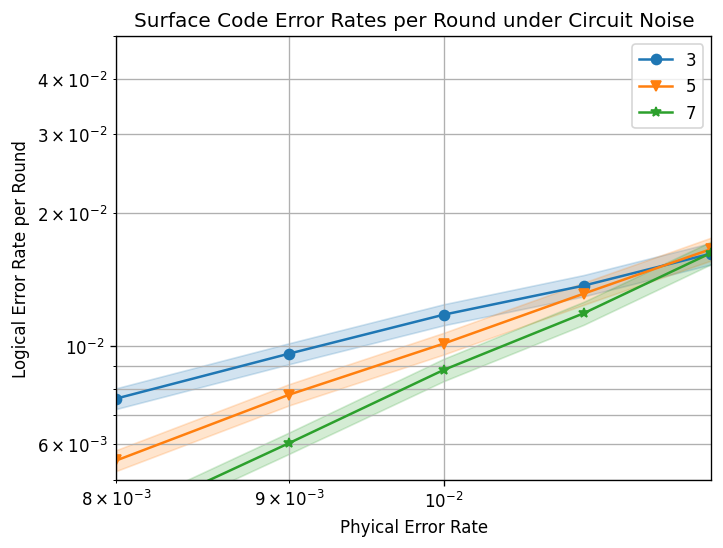

In [31]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

### 4.2.2 - estimate # of qubits for fault-tolerance

[TODO, 2.0pts]: Next, fix the depolarizing noise probability to $p = 0.001$, inspired by SOTA performance in transmon-based surface codes. As we did for the cat-repetition code, make a plot of logical error rate versus code distance $d$, which is equal to $\sqrt{n}$ for the square surface code, where $n$ is the number of data qubits. Use your `generate_surface_code_depolarizing_noise` function. The lower ylim of your plot should be `goal_logical_error_rate`.

Starting 2 workers...


Running Surface Code simulations (this may take a moment)...


4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata
        1 pymatching <1m    1993583         993 d=3,p=0.001  
        1 pymatching   ?    2000000        1000 d=5,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=7,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=9,p=0.001  
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata
        1 pymatching <1m    1950575         932 d=3,p=0.001  
        1 pymatching   ?    2000000        1000 d=5,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=7,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=9,p=0.001  
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata
        1 pymatching <1m    1885039         841 d=3,p=0.001  
        1 pymatching   ?    2000000        1000 d=5,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=7,p=0.001  
        0 pymatching ?·∞    2000000        1000 d=9,p=0.001  
4 tasks left:
  workers    d


Results:
Slope (Lambda): -0.4877
Projected distance for 1e-10: 17.69
Recommended Surface Code Distance: d = 18


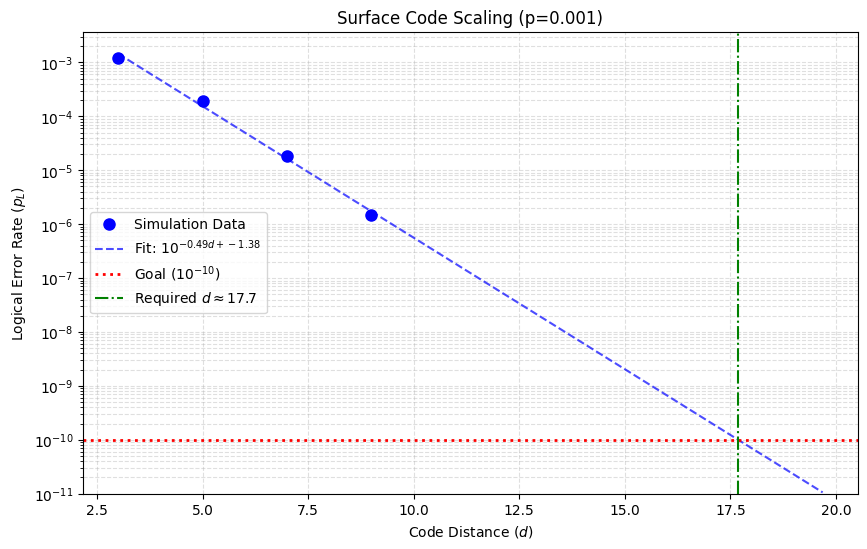

In [32]:
noise = 1e-3
goal_logical_error_rate = 1e-10

import scipy.stats
import numpy as np

# SOLUTION ===

# 1. SETUP PARAMETERS
# We sweep distance to see how error rate suppresses with size
distances = [3, 5, 7, 9]

# 2. RUN SIMULATION
# We use the function from 4.2.1: generate_surface_code_depolarizing_noise
tasks = [
    sinter.Task(
        circuit=generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in distances
]

print("Running Surface Code simulations (this may take a moment)...")
collected_stats = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=2_000_000, # Need high shots to see errors at d=9
    max_errors=1_000,
    print_progress=True,
)

# 3. EXTRACT DATA & FIT
d_values = []
log_error_rates = []

for stat in collected_stats:
    if stat.errors > 0:
        d = stat.json_metadata['d']
        # Rate per shot (standard metric for these plots)
        rate = stat.errors / stat.shots
        d_values.append(d)
        log_error_rates.append(np.log10(rate))

# Linear Regression: log10(pL) ~ slope * d + intercept
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(d_values, log_error_rates)

# Calculate required distance for goal (1e-10)
target_log = np.log10(goal_logical_error_rate)
required_d = (target_log - intercept) / slope

print(f"\nResults:")
print(f"Slope (Lambda): {slope:.4f}")
print(f"Projected distance for 1e-10: {required_d:.2f}")
print(f"Recommended Surface Code Distance: d = {int(np.ceil(required_d))}")

# 4. PLOTTING
plt.figure(figsize=(10, 6))

# Plot the raw simulation data points
plt.semilogy(d_values, [10**y for y in log_error_rates], 'bo', markersize=8, label='Simulation Data')

# Plot the best-fit line (extrapolating out to the goal)
x_fit = np.linspace(min(distances), required_d + 2, 50)
y_fit = 10**(slope * x_fit + intercept)
plt.semilogy(x_fit, y_fit, 'b--', alpha=0.7, label=f'Fit: $10^{{{slope:.2f} d + {intercept:.2f}}}$')

# Plot the Goal Line (Bottom limit)
plt.axhline(y=goal_logical_error_rate, color='r', linestyle=':', linewidth=2, label='Goal ($10^{-10}$)')
plt.axvline(x=required_d, color='g', linestyle='-.', label=f'Required $d \\approx {required_d:.1f}$')

# Formatting
plt.title(f"Surface Code Scaling (p={noise})")
plt.xlabel("Code Distance ($d$)")
plt.ylabel("Logical Error Rate ($p_L$)")
plt.ylim(bottom=goal_logical_error_rate * 0.1) # Ensure the goal is visible at the bottom
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()

# ===

[TODO, 0.5pts]: Finally, compare the performance of the cat-repetition code to the surface code. In particular, comment on the resource requirements and potential challenges of both approaches.

When using surface code, the number of qubits needed to achieve 10^-10 error rate is more than the number of qubits needed for cat-repetition code.
Challenge: for surface code, the quantum circuit is much more complicated; for cat code, the challenge is engineering physical cat-states (e.g. using quantum harmonic oscillator)

# 5 - Quantum error correction inspired by classical codes

## Core Task 5.1 - Explore QEC codes inspired by classical codes

[TODO, 70pts]:

Classical error correcting codes provide a natural and powerful pathway to constructing quantum codes by directly translating classical parity checks into quantum stabilizer measurements. In particular, any linear classical code can be mapped to a quantum code that detects and corrects **bit flip (X) errors** by promoting each classical parity check into a multi-qubit ( Z )-type stabilizer. In this construction, classical codewords become logical quantum states, and the syndrome extraction process is identical in spirit to classical decoding. This approach is especially well suited for hardware with **strong noise bias**, where one error channel dominates. In our case, biased cat qubits exponentially suppress phase flip errors, leaving bit flips as the primary failure mode. As a result, we can focus entirely on X-error correction, allowing us to use a much wider and more efficient family of classical codes than would be possible for fully general quantum noise.

The final and core challenge is to choose any classical error correcting code (or family of codes), translate it into its quantum counterpart, and benchmark it against the repetition code that you already implemented. You will simulate the resulting quantum code in **Stim**, extract syndromes, perform decoding, and compare key performance metrics such as logical error rate versus number of physical qubits at a fixed physical error rate, encoding efficiency ( k/n ), the effective distance of the code and required hardware connectivity (i.e. what two-qubit gates are needed). This exploration will show how classical coding theory can be directly leveraged to design quantum codes that outperform simple repetition strategies when the noise is strongly biased.

*Optionally*, only if time permits, you may wish to demonstrate a universal, fault-tolerant set of logical gates for your code, starting with the Clifford group and extending to non-Clifford gates.


Please refer to `./2-classical-to-quantum-codes.ipynb` for a step-by-step introduction to translating a classical code into a quantum bit-flip–correcting code, along with a curated (but not exhaustive) list of classical code families to use as inspiration. You should consider this notebook required reading for the core task in this challenge.

This is an open-ended challenge, judged by the criteria specified in the `README.md` doc.